# Classification and Segmentation

## CS194-26 Project 4, Spring 2020

### by Sukrit Arora 

#### sukrit.arora@berkeley.edu -- cs194-ahb

In [3]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:0.9em;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Georgia';
font-size:1.2em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}

.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
""")



## Part 1 – Image Classification

The first part of this project is an image classifier for the Fashion-MNIST dataset, built in PyTorch. The network I created for classification is a 5 layer network, with 2 Convolution layers and 3 Fully Connected layers. The architecture resembles the following:

$$\big(\text{Conv} \longrightarrow \text{ReLU} \longrightarrow \text{MaxPool}\big) \times 2 \longrightarrow \big(\text{FC} \longrightarrow \text{ReLU}\big) \times 2 \longrightarrow \text{FC}$$

The parameters for the Conv and FC layers can be seen below.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [43]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(32 * 5 * 5, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, np.prod(x.size()[1:]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

train_size = int(0.8*len(trainset))
train_set, val_set = torch.utils.data.random_split(trainset, [train_size, len(trainset)-train_size])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=50,
                                         shuffle=False, num_workers=2)

classes = {v: k for k, v in trainset.class_to_idx.items()}

A quick visualization of our dataset, with the class labels:

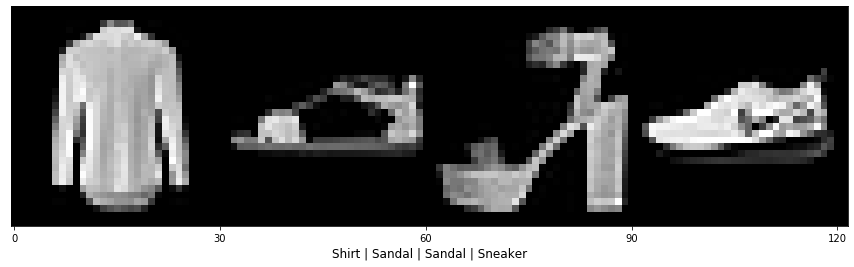

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.figure(figsize=(15,10))
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:4,...]).numpy(), (1, 2, 0)))
plt.xlabel(' | '.join('%5s' % classes[labels[j].item()] for j in range(4)), size=12)
plt.xticks([30*i for i in range(5)])
plt.yticks([])
plt.show()

In [111]:
# Run this code to train. To load, run the loading code below.

num_epochs = 10
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_acc = np.zeros(num_epochs)
val_acc = np.zeros(num_epochs)

for epoch in range(num_epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(images)
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update
        running_loss += loss.item()
        if i % 100 == 0:
            print ('Iteration %05d Train loss %f' % (i, running_loss/100), '\r', end='')
            running_loss=0
    with torch.no_grad():
        total = 0
        correct = 0
        for i, (images, labels) in enumerate(trainloader):
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc[epoch] = correct/total*100

        total = 0
        correct = 0
        for i, (images, labels) in enumerate(valloader):
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_acc[epoch] = correct/total*100

In [161]:
# Saving data
# torch.save(net.state_dict(), './mnist_net.pth') # Saving state dict
# np.save("train_acc", train_acc) # Saving train acc
# np.save("val_acc", val_acc) # Saving train acc

In [44]:
# Loading data
net = Net()
net.load_state_dict(torch.load('./mnist_net.pth'))
train_acc = np.load("train_acc.npy")
val_acc = np.load("val_acc.npy")

A plot of the training and validation accuracy during training (calculated very epoch). As we can see in the plot below, we overfit a bit to the training data, but the network still performs well on the validation set.

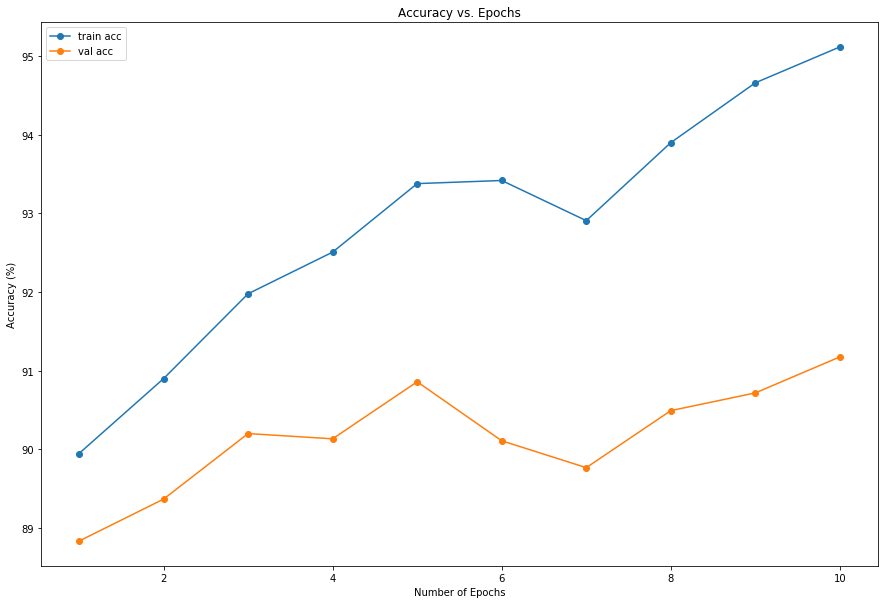

In [48]:
plt.figure(figsize=(15,10))
plt.plot(range(1,11),train_acc, label="train acc", marker="o")
plt.plot(range(1,11), val_acc, label="val acc", marker="o")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epochs")
plt.legend()
plt.show()

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for (images, labels) in testloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

Accuracy of the network on the test set:

In [11]:
print("Accuracy of the network on the {0} test images: {1:.2f} %".format(total,100 * correct / total))

Accuracy of the network on the 10000 test images: 90.76 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(50):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [13]:
print("Per Class Accuracy")
print("-"*25)
for i in range(10):
    print("{0:^11s} : {1:.2f} %".format(classes[i], 100 * class_correct[i] / class_total[i]))

Per Class Accuracy
-------------------------
T-shirt/top : 86.60 %
  Trouser   : 96.80 %
 Pullover   : 91.20 %
   Dress    : 93.10 %
   Coat     : 82.00 %
  Sandal    : 96.60 %
   Shirt    : 70.40 %
  Sneaker   : 96.70 %
    Bag     : 97.20 %
Ankle boot  : 97.00 %


As we can see in the Per Class Accuracy table above, the network performs extremely well for the Bag and Ankle Boot classes, but not as well for the Shirt and Coat classes. This is probably due to the high variance in the input dataset for the poorly performing classes.

In [14]:
correct_ex = np.zeros((10, 2, 1, 28, 28))
correct_ex_tally = np.zeros(10, dtype=int)
incorrect_ex = np.zeros((10, 2, 1, 28, 28))
incorrect_ex_tally = np.zeros(10, dtype=int)

with torch.no_grad():
    for data in testloader:
        if all([tally==2 for tally in correct_ex_tally]) and all([tally==2 for tally in incorrect_ex_tally]):
            break
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(50):
            label = labels[i]
            classified_correct = c[i].item()
            if classified_correct and correct_ex_tally[label] != 2:
                correct_ex[label, correct_ex_tally[label]] = images[i]
                correct_ex_tally[label] += 1
            elif not classified_correct and incorrect_ex_tally[label] != 2:
                incorrect_ex[label, incorrect_ex_tally[label]] = images[i]
                incorrect_ex_tally[label] += 1
            if all([tally==2 for tally in correct_ex_tally]) and all([tally==2 for tally in incorrect_ex_tally]):
                break

Below is a visualization of data points (images) that the network classifies correctly and incorrectly.

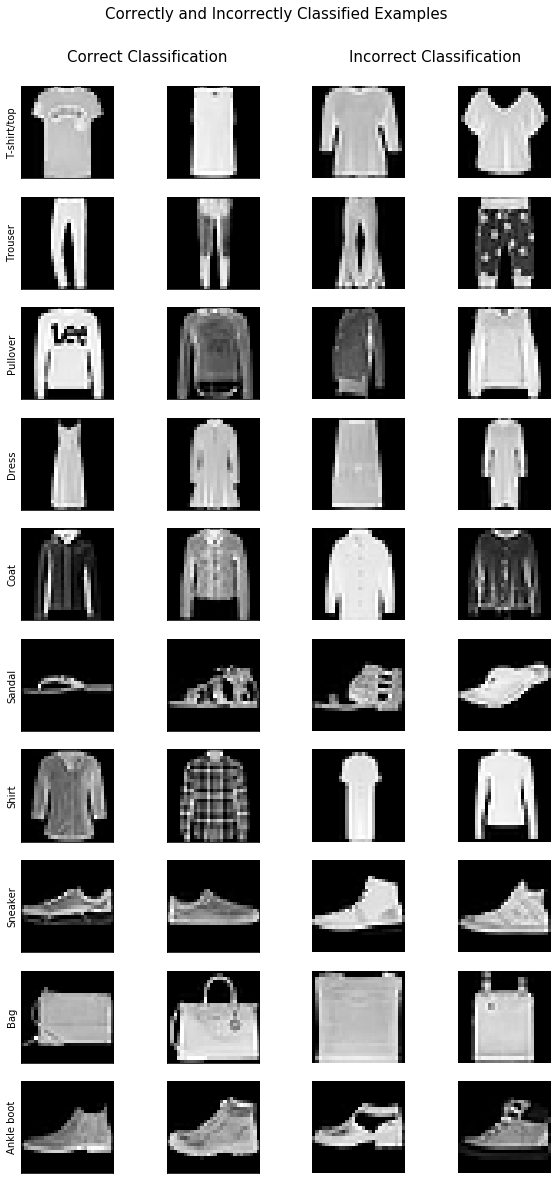

In [15]:
fig = plt.figure(figsize=(10,20))
fig.suptitle("Correctly and Incorrectly Classified Examples", fontsize=15, ha="center", va="center", y=0.93)
plt.figtext(0.32,0.9,"Correct Classification", va="center", ha="center", size=15)
plt.figtext(0.72,0.9,"Incorrect Classification", va="center", ha="center", size=15)
for class_no in range(10):
    for i in range(2):
        plt.subplot(10, 4, 4*class_no+i+1)
        plt.imshow(correct_ex[class_no, i, 0], cmap="gray")
#         plt.title("Correct Ex {}".format(i+1))
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(classes[class_no])
    for i in range(2):
        plt.subplot(10, 4, 4*class_no+3+i)
        plt.imshow(incorrect_ex[class_no, i, 0], cmap="gray")
#         plt.title("Incorrect Ex {}".format(i+1))
        plt.axis("off")

Below is a visualization of the filters learned in the first Convolution layer of the network.

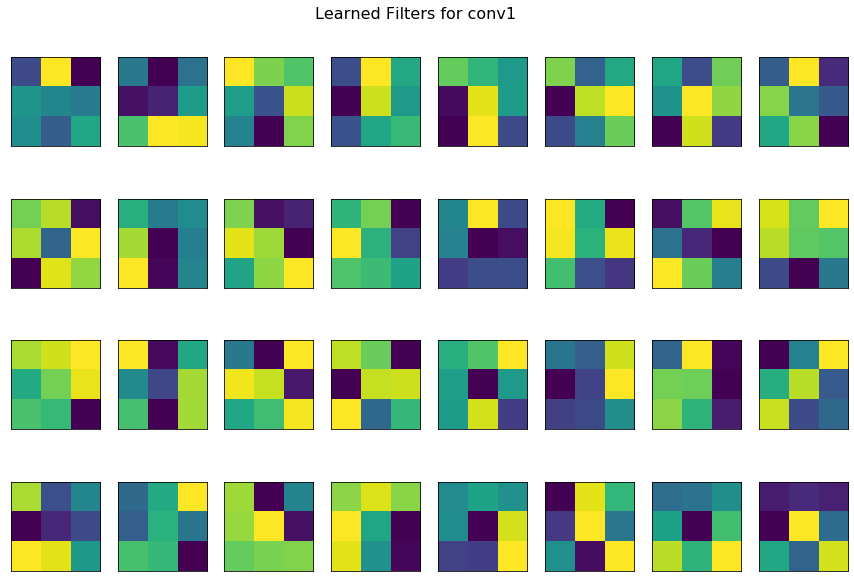

In [16]:
filters = np.transpose(net.conv1.weight.data, (0, 2, 3, 1))[...,0]
fig = plt.figure(figsize=(15,10))
fig.suptitle("Learned Filters for conv1", fontsize=16, y=0.93)
for i, filt in enumerate(filters, 1):
    plt.subplot(4, 8, i)
    plt.imshow(filt)
    plt.xticks([])
    plt.yticks([])
#     plt.tight_layout()

## Part 2 – Image Segmentation

Semantic Segmentation refers to labeling each pixel in the image to its correct object class. For this part, I used a Mini Facade dataset, which consists of images of different cities around the world and diverse architectural styles and their semantic segmentation labels in 5 different classes: balcony, window, pillar, facade and others. Using this dataset, I trained a deep neural network of my design to perform semantic segmentation.

In [25]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, './part2')
import part2.dataset
import part2.train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
net = part2.train.Net()
net.load_state_dict(torch.load('./part2/models/model_starter_net.pth',map_location=torch.device('cpu')))

ap_data = part2.dataset.FacadeDataset(dataDir='part2/starter_set',flag='test_dev', data_range=(0,114), onehot=True)
ap_loader = torch.utils.data.DataLoader(ap_data, batch_size=1)

train_loss = np.load("part2/train_loss.npy")
val_loss = np.load("part2/val_loss.npy")

load test_dev dataset start
    from: part2/starter_set
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: part2/starter_set
    range: [0, 114)
load dataset done


My network architecture is shown below. The general idea was to increase channel depth as I decrease the spatial dimension, and then to decrease channel depth as I increase the spatial dimensions.

I used Cross Entropy Loss as my loss function, and the ADAM optimizer with a learning rate of $10^{-3}$ and a weight decay of $10^{-5}$ as my solver. I did a 90-10 split for my training-validation datasets. I trained my network for $15$ epochs and tuned my networks parameters based on the results on the validation set.

In [40]:
print(net)

Net(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Upsample(size=128, mode=nearest)
    (13): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(256, 5, kernel_size=(3, 3), stride=(1, 1))
    (16): Upsample(size=256, mode=nearest)
  )
)


A plot of the training and validation loss during training (calculated very epoch) is shown below.

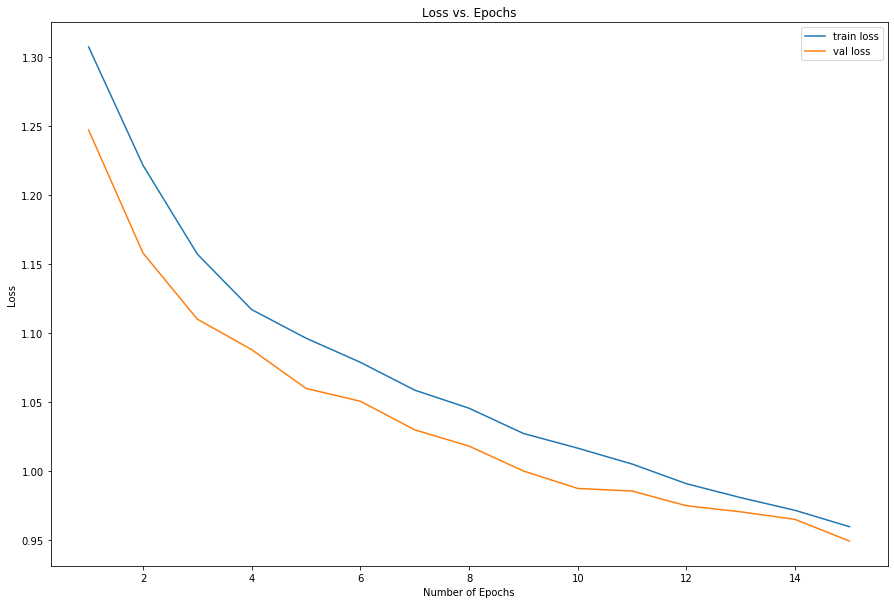

In [51]:
plt.figure(figsize=(15,10))
plt.plot(range(1,16),train_loss, label="train loss")
plt.plot(range(1,16), val_loss, label="val loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.show()

The Average Precision, per class and the average across classes is below.

In [26]:
aps = part2.train.cal_AP(ap_loader, net, nn.CrossEntropyLoss(), "cpu")

Calculating average precision


100%|██████████| 114/114 [02:06<00:00,  1.11s/it]


AP = 0.6236969991244149
AP = 0.6707720863964722
AP = 0.14891772864873343
AP = 0.5804183405117497
AP = 0.40463147396499544


In [39]:
print("Average AP across classes: {}".format(np.mean(aps)))

Average AP across classes: 0.48568732572927314


In [34]:
im_no = 65
folder = "part2/output_test/"
image_types = ["x", "gt", "y"]
images = [plt.imread(folder+im_t+str(im_no)+".png") for im_t in image_types]

A sample data point (image) from the dataset, its ground truth, and the network output is shown below. As a reference, here is a table of the 5 classes and their corresponding colors: ![Table](table.png)


As we can see, the network performs decently well for such a challenging task. It more or less classifies the broad regions correctly, but it is clear that the classification is very coarse. 

Additionally, it performs quite well for the facade and windows, but quite poorly for the pillars.

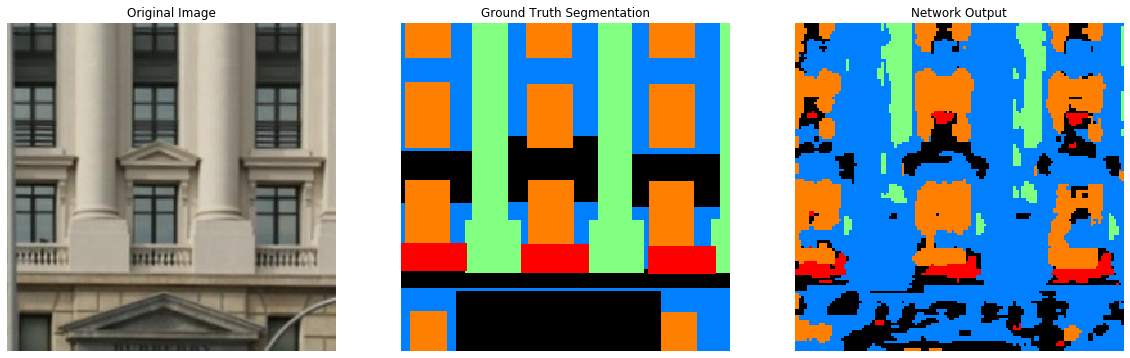

In [52]:
titles = ["Original Image", "Ground Truth Segmentation", "Network Output"]
plt.figure(figsize=(20,20))
for i, image in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(titles[i])